In [120]:
#new plotting code
#new samples (5000)

# Imports

In [121]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import lalsimulation as lal
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
import keras
import keras_metrics as km
import keras
import keras_metrics as km
from keras import metrics

In [122]:
gamma0 = np.loadtxt("eos_polytrope_gamma_0-5000.dat.txt", dtype=float)
gamma1 = np.loadtxt("eos_polytrope_gamma_1-5000.dat.txt", dtype=float)
gamma2 = np.loadtxt("eos_polytrope_gamma_2-5000.dat.txt", dtype=float)
l1 = np.loadtxt('lambda_1-5000.dat.txt', dtype=float)
l2 = np.loadtxt('lambda_2-5000.dat.txt', dtype=float)
logp1_cgs = np.loadtxt("eos_polytrope_log_pressure_1-5000.dat.txt", dtype=float)
logp2_cgs = np.loadtxt("eos_polytrope_log_pressure_2-5000.dat.txt", dtype=float)
m1 = np.loadtxt("mass_1_source-5000.dat.txt", dtype=float)
m2 = np.loadtxt("mass_2_source-5000.dat.txt", dtype=float)

In [123]:
len(m2)

5000

In [124]:
logp1_s = logp1_cgs - 1
logp2_s = logp2_cgs - 1

# Functions

In [94]:
#formatting array & processing outputs

def format_output(data):
    gamma0 = data.pop('gamma0')
    gamma0 = np.array(gamma0)
    gamma1 = data.pop('gamma1')
    gamma1 = np.array(gamma1)
    gamma2 = data.pop('gamma2')
    gamma2 = np.array(gamma2)
    logp1_si = data.pop('logp1_si')
    logp1_si = np.array(logp1_si)
    logp2_si = data.pop('logp2_si')
    logp2_si = np.array(logp2_si)
    return gamma0, gamma1, gamma2, logp1_si, logp2_si



In [95]:
#normalize and save the new array, and the max

def minmax(inputarray):
    
    absinput = np.abs(inputarray)
    gmax = absinput.max()
    newarray = inputarray / gmax
                
    return newarray, gmax


In [96]:
#return inputs back to original values in order to plot EOS

def unnorm(predictionsarray, gam0max, gam1max, gam2max, logp1max, logp2max):
    
    for i in range (len(predictionsarray)):
        new_gamma0_array = predictionsarray[0] * gam0max
        new_gamma1_array = predictionsarray[1] * gam1max
        new_gamma2_array = predictionsarray[2] * gam2max
        new_logp1_array = predictionsarray[3] *  logp1max
        new_logp2_array = predictionsarray[4] *  logp2max
    
    new_array = np.concatenate((new_gamma0_array, new_gamma1_array, new_gamma2_array, new_logp1_array, new_logp2_array), axis=1)

    return new_array

# MLA

In [65]:
# not normalized

#l1_dat = (l1)
#l2_dat = (l2)
#m1_dat = (m1)
#m2_dat = (m2)

#sd_gamma0 = (gamma0)
#sd_gamma1 = (gamma1)
#sd_gamma2 = (gamma2)
#logp1_si  = (logp1_s)
#logp2_si  = (logp2_s)

In [66]:
#normalizing inputs and outputs

l1_dat, l1max = minmax(l1)
l2_dat, l2max = minmax(l2)
m1_dat, m1max = minmax(m1)
m2_dat, m2max = minmax(m2)


sd_gamma0, gam0max = minmax(gamma0)
sd_gamma1, gam1max = minmax(gamma1)
sd_gamma2, gam2max = minmax(gamma2)
logp1_si, logp1max = minmax(logp1_s)
logp2_si, logp2max = minmax(logp2_s)


In [67]:
#create an empty array 8 x length(m1_dat]) for vals
array_size =  np.array([[0] * 9 ] * len(sd_gamma0))
array_size = array_size.astype('float64')
combined_array = np.zeros_like(array_size)
print(combined_array.dtype)
print(combined_array.shape)

float64
(5000, 9)


In [68]:
#reformat data files into this new array
for i in range(0,len(m1_dat)-1):
    combined_array[i][0] = m1_dat[i]
    combined_array[i][1] = m2_dat[i]
    combined_array[i][2] = l1_dat[i]
    combined_array[i][3] = l2_dat[i]
    combined_array[i][4] = sd_gamma0[i]
    combined_array[i][5] = sd_gamma1[i]
    combined_array[i][6] = sd_gamma2[i]
    combined_array[i][7] = logp1_si[i]
    combined_array[i][8] = logp2_si[i]
    

In [69]:
data = pd.DataFrame(combined_array)
data.columns = ['m1','m2', 'l1', 'l2','gamma0', 'gamma1', 'gamma2', 'logp1_si', 'logp2_si']
print(data)

            m1        m2            l1            l2    gamma0    gamma1  \
0     0.457100  0.269010  1.231631e-15  1.231631e-15  0.550023  0.832864   
1     0.180815  0.139755  1.083181e-12  1.083181e-12  0.719164  0.796504   
2     0.521504  0.465191  4.257915e-15  4.257915e-15  0.704148  0.990650   
3     0.156245  0.103609  1.230363e-12  1.230363e-12  0.583490  0.230004   
4     0.719877  0.704714  1.298472e-15  1.298472e-15  0.850621  0.664390   
...        ...       ...           ...           ...       ...       ...   
4995  0.327068  0.104144  6.730851e-14  6.730851e-14  0.723516  0.813787   
4996  0.433991  0.377032  2.445574e-14  2.445574e-14  0.839006  0.722729   
4997  0.555450  0.237535  4.163172e-15  4.163172e-15  0.758609  0.480323   
4998  0.375074  0.325988  3.537261e-15  3.537261e-15  0.906993  0.438098   
4999  0.000000  0.000000  0.000000e+00  0.000000e+00  0.000000  0.000000   

        gamma2  logp1_si  logp2_si  
0     0.384838  0.955998  0.965722  
1     0.53898

In [70]:
#split data into train and test

data = data.sample(frac=1).reset_index(drop=True)

train, test = train_test_split(data, test_size=0.2)

print(train)

train_stats = train.describe()

#get gamma as the outputs and format them as np arrays.

train_stats.pop('gamma0')
train_stats.pop('gamma1')
train_stats.pop('gamma2')
train_stats.pop('logp1_si')
train_stats.pop('logp2_si')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

            m1        m2            l1            l2    gamma0    gamma1  \
4415  0.522709  0.418417  4.361478e-15  4.361478e-15  0.709061  0.202856   
4033  0.534310  0.192108  7.754817e-15  7.754817e-15  0.958142  0.674159   
2318  0.254389  0.183465  1.994670e-13  1.994670e-13  0.690668  0.838585   
2115  0.461127  0.349529  2.681086e-14  2.681086e-14  0.988791  0.979258   
4140  0.833975  0.433531  1.507233e-16  1.507233e-16  0.766391  0.822312   
...        ...       ...           ...           ...       ...       ...   
1157  0.762772  0.252522  1.197412e-15  1.197412e-15  0.952733  0.943864   
2046  0.481994  0.492845  2.043597e-15  2.043597e-15  0.546829  0.773647   
4148  0.433509  0.281444  5.569819e-15  5.569819e-15  0.430530  0.835679   
3521  0.598528  0.498591  6.556112e-15  6.556112e-15  0.982324  0.831308   
3512  0.534120  0.407470  1.274057e-14  1.274057e-14  0.989436  0.269255   

        gamma2  logp1_si  logp2_si  
4415  0.494672  0.947156  0.968036  
4033  0.52382

In [71]:
norm_train_X = train
norm_test_X = test

In [72]:

input_layer = Input(shape=(len(train .columns),))

first_dense = Dense(units='128', activation='tanh')(input_layer)
second_dense = Dense(units='128', activation='tanh')(first_dense)
third_dense = Dense(units='128', activation='tanh')(second_dense)
fourth_dense = Dense(units='128', activation='tanh')(third_dense)
fifth_dense = Dense(units='128', activation='tanh')(fourth_dense)
sixth_dense = Dense(units='128', activation='tanh')(fifth_dense)
seventh_dense = Dense(units='128', activation='tanh')(sixth_dense)
eight_dense = Dense(units='128', activation='tanh')(seventh_dense)
ninth_dense = Dense(units='128', activation='tanh')(eight_dense)
    
tenth_dense = Dense(units='128', activation='tanh')(ninth_dense)
eleventh_dense = Dense(units='128', activation='tanh')(tenth_dense)
twelth_dense = Dense(units='128', activation='tanh')(eleventh_dense)
thirteenth_dense = Dense(units='128', activation='tanh')(twelth_dense)
fourteenth_dense = Dense(units='128', activation='tanh')(thirteenth_dense)
fifteenth_dense = Dense(units='128', activation='tanh')(fourteenth_dense)
sixteenth_dense = Dense(units='128', activation='tanh')(fifteenth_dense)
seventeenth_dense = Dense(units='128', activation='tanh')(sixteenth_dense)
eighteenth_dense = Dense(units='128', activation='tanh')(seventeenth_dense)
nineteenth_dense = Dense(units='128', activation='tanh')(eighteenth_dense)
    
twentieth_dense = Dense(units='128', activation='tanh')(nineteenth_dense)
tf_dense = Dense(units='128', activation='tanh')(twentieth_dense)
ts_dense = Dense(units='128', activation='tanh')(tf_dense)
tt_dense = Dense(units='128', activation='tanh')(ts_dense)
tfo_dense = Dense(units='128', activation='tanh')(tt_dense)
tfi_dense = Dense(units='128', activation='tanh')(tfo_dense)
ts_dense = Dense(units='128', activation='tanh')(tfi_dense)
tse_dense = Dense(units='128', activation='tanh')(ts_dense)
te_dense = Dense(units='128', activation='tanh')(tse_dense)
tn_dense = Dense(units='128', activation='tanh')(te_dense)


gamma0_output = Dense(units='1', activation='tanh', name='gamma0_output')(tn_dense)
thf_dense = Dense(units='64', activation='tanh')(tn_dense)

ths_dense = Dense(units='128', activation='tanh')(thf_dense)
tht_dense = Dense(units='128', activation='tanh')(ths_dense)
thfo_dense = Dense(units='128', activation='tanh')(tht_dense)
thfi_dense = Dense(units='128', activation='tanh')(thfo_dense)
ths_dense = Dense(units='128', activation='tanh')(thfi_dense)
thse_dense = Dense(units='128', activation='tanh')(ths_dense)
the_dense = Dense(units='128', activation='tanh')(thse_dense)
thn_dense = Dense(units='128', activation='tanh')(the_dense)

gamma1_output = Dense(units='1', activation='tanh', name='gamma1_output')(thn_dense)
fo_dense = Dense(units='32',activation='tanh')(thn_dense)

fof_dense = Dense(units='128', activation='tanh')(fo_dense)
fos_dense = Dense(units='128', activation='tanh')(fof_dense)
fot_dense = Dense(units='128', activation='tanh')(fos_dense)
fofo_dense = Dense(units='128', activation='tanh')(fot_dense)
fofi_dense = Dense(units='128', activation='tanh')(fofo_dense)

gamma2_output = Dense(units='1', activation='tanh', name='gamma2_output')(fofi_dense)
fos_dense = Dense(units='16',activation='tanh')(fofi_dense)

fose_dense = Dense(units='128', activation='tanh')(fos_dense)
foe_dense = Dense(units='128', activation='tanh')(fose_dense)
fon_dense = Dense(units='128', activation='tanh')(foe_dense)
fif_dense = Dense(units='128', activation='tanh')(fon_dense)

logp1_si_output = Dense(units='1', activation='tanh', name='logp1_si_output')(fon_dense)

fiff_dense = Dense(units='128', activation='tanh')(fon_dense)
fifs_dense = Dense(units='128', activation='tanh')(fiff_dense)
fift_dense = Dense(units='128', activation='tanh')(fifs_dense)
fiff_dense = Dense(units='128', activation='tanh')(fift_dense)
fiffi_dense = Dense(units='128', activation='tanh')(fiff_dense)
fifs_dense = Dense(units='128', activation='tanh')(fiffi_dense)

logp2_si_output = Dense(units='1', activation='tanh', name='logp2_si_output')(fifs_dense)


model = Model(inputs=input_layer, outputs=[gamma0_output, gamma1_output, gamma2_output, logp1_si_output, logp2_si_output])

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 dense_55 (Dense)               (None, 128)          640         ['input_2[0][0]']                
                                                                                                  
 dense_56 (Dense)               (None, 128)          16512       ['dense_55[0][0]']               
                                                                                                  
 dense_57 (Dense)               (None, 128)          16512       ['dense_56[0][0]']               
                                                                                            

 dense_94 (Dense)               (None, 128)          4224        ['dense_93[0][0]']               
                                                                                                  
 dense_95 (Dense)               (None, 128)          16512       ['dense_94[0][0]']               
                                                                                                  
 dense_96 (Dense)               (None, 128)          16512       ['dense_95[0][0]']               
                                                                                                  
 dense_97 (Dense)               (None, 128)          16512       ['dense_96[0][0]']               
                                                                                                  
 dense_98 (Dense)               (None, 128)          16512       ['dense_97[0][0]']               
                                                                                                  
 dense_99 

In [73]:
#plot_model(model, to_file='DynamicPolytropeMLA.png', show_shapes=True, show_layer_names=True)

In [74]:
#specify the optimizer as stochastic gradient descent and will mention the learning rate as 0.001
#compile the model with loss functions for both outputs
from keras import metrics

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss={'gamma0_output': 'mse', 'gamma1_output': 'mse', 'gamma2_output': 'mse', 'logp1_si_output': 'mse', 'logp2_si_output': 'mse'},
              metrics={
                       'gamma0_output': tf.keras.metrics.MeanSquaredError() ,
                       'gamma1_output': tf.keras.metrics.MeanSquaredError(),
                       'gamma2_output': tf.keras.metrics.MeanSquaredError() ,
                       'logp1_si_output': tf.keras.metrics.MeanSquaredError(),
                       'logp2_si_output': tf.keras.metrics.MeanSquaredError()
                      })

endmetric = "mean_squared_error"

In [75]:
#train the model for a number of epochs

numepochs = 200
    
history = model.fit(norm_train_X.to_numpy(), train_Y,
                    epochs=numepochs, batch_size=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001,patience=50,mode='auto')])


Epoch 1/200
320/320 [==============================] - 9s 16ms/step - loss: 0.1239 - gamma0_output_loss: 0.0381 - gamma1_output_loss: 0.0526 - gamma2_output_loss: 0.0207 - logp1_si_output_loss: 0.0064 - logp2_si_output_loss: 0.0060 - gamma0_output_mean_squared_error: 0.0381 - gamma1_output_mean_squared_error: 0.0526 - gamma2_output_mean_squared_error: 0.0207 - logp1_si_output_mean_squared_error: 0.0064 - logp2_si_output_mean_squared_error: 0.0060 - val_loss: 0.0978 - val_gamma0_output_loss: 0.0300 - val_gamma1_output_loss: 0.0483 - val_gamma2_output_loss: 0.0162 - val_logp1_si_output_loss: 0.0017 - val_logp2_si_output_loss: 0.0016 - val_gamma0_output_mean_squared_error: 0.0300 - val_gamma1_output_mean_squared_error: 0.0483 - val_gamma2_output_mean_squared_error: 0.0162 - val_logp1_si_output_mean_squared_error: 0.0017 - val_logp2_si_output_mean_squared_error: 0.0016
Epoch 2/200
320/320 [==============================] - 4s 11ms/step - loss: 0.1026 - gamma0_output_loss: 0.0346 - gamma1_o

320/320 [==============================] - 4s 13ms/step - loss: 0.0968 - gamma0_output_loss: 0.0327 - gamma1_output_loss: 0.0466 - gamma2_output_loss: 0.0163 - logp1_si_output_loss: 7.4631e-04 - logp2_si_output_loss: 4.4540e-04 - gamma0_output_mean_squared_error: 0.0327 - gamma1_output_mean_squared_error: 0.0466 - gamma2_output_mean_squared_error: 0.0163 - logp1_si_output_mean_squared_error: 7.4631e-04 - logp2_si_output_mean_squared_error: 4.4540e-04 - val_loss: 0.0993 - val_gamma0_output_loss: 0.0313 - val_gamma1_output_loss: 0.0488 - val_gamma2_output_loss: 0.0159 - val_logp1_si_output_loss: 0.0018 - val_logp2_si_output_loss: 0.0016 - val_gamma0_output_mean_squared_error: 0.0313 - val_gamma1_output_mean_squared_error: 0.0488 - val_gamma2_output_mean_squared_error: 0.0159 - val_logp1_si_output_mean_squared_error: 0.0018 - val_logp2_si_output_mean_squared_error: 0.0016
Epoch 20/200
320/320 [==============================] - 4s 13ms/step - loss: 0.0967 - gamma0_output_loss: 0.0327 - gam

320/320 [==============================] - 4s 14ms/step - loss: 0.0965 - gamma0_output_loss: 0.0326 - gamma1_output_loss: 0.0465 - gamma2_output_loss: 0.0162 - logp1_si_output_loss: 7.2984e-04 - logp2_si_output_loss: 4.3956e-04 - gamma0_output_mean_squared_error: 0.0326 - gamma1_output_mean_squared_error: 0.0465 - gamma2_output_mean_squared_error: 0.0162 - logp1_si_output_mean_squared_error: 7.2984e-04 - logp2_si_output_mean_squared_error: 4.3956e-04 - val_loss: 0.0967 - val_gamma0_output_loss: 0.0301 - val_gamma1_output_loss: 0.0474 - val_gamma2_output_loss: 0.0159 - val_logp1_si_output_loss: 0.0018 - val_logp2_si_output_loss: 0.0016 - val_gamma0_output_mean_squared_error: 0.0301 - val_gamma1_output_mean_squared_error: 0.0474 - val_gamma2_output_mean_squared_error: 0.0159 - val_logp1_si_output_mean_squared_error: 0.0018 - val_logp2_si_output_mean_squared_error: 0.0016
Epoch 38/200
320/320 [==============================] - 4s 14ms/step - loss: 0.0963 - gamma0_output_loss: 0.0327 - gam

320/320 [==============================] - 5s 16ms/step - loss: 0.0960 - gamma0_output_loss: 0.0325 - gamma1_output_loss: 0.0463 - gamma2_output_loss: 0.0161 - logp1_si_output_loss: 7.2611e-04 - logp2_si_output_loss: 4.3764e-04 - gamma0_output_mean_squared_error: 0.0325 - gamma1_output_mean_squared_error: 0.0463 - gamma2_output_mean_squared_error: 0.0161 - logp1_si_output_mean_squared_error: 7.2611e-04 - logp2_si_output_mean_squared_error: 4.3764e-04 - val_loss: 0.0981 - val_gamma0_output_loss: 0.0302 - val_gamma1_output_loss: 0.0486 - val_gamma2_output_loss: 0.0160 - val_logp1_si_output_loss: 0.0018 - val_logp2_si_output_loss: 0.0016 - val_gamma0_output_mean_squared_error: 0.0302 - val_gamma1_output_mean_squared_error: 0.0486 - val_gamma2_output_mean_squared_error: 0.0160 - val_logp1_si_output_mean_squared_error: 0.0018 - val_logp2_si_output_mean_squared_error: 0.0016
Epoch 56/200
320/320 [==============================] - 5s 16ms/step - loss: 0.0962 - gamma0_output_loss: 0.0326 - gam

In [76]:
loss, gamma0_loss, gamma0_accuracy, gamma1_loss, gamma1_accuracy, gamma2_loss, gamma2_accuracy, logp1_si_loss, logp1_si_accuracy, logp2_si_loss, logp2_si_accuracy = model.evaluate(x=norm_test_X.to_numpy(), y=test_Y)


32/32 [==============================] - 1s 6ms/step - loss: 0.0965 - gamma0_output_loss: 0.0324 - gamma1_output_loss: 0.0472 - gamma2_output_loss: 0.0156 - logp1_si_output_loss: 7.4538e-04 - logp2_si_output_loss: 4.5792e-04 - gamma0_output_mean_squared_error: 0.0324 - gamma1_output_mean_squared_error: 0.0472 - gamma2_output_mean_squared_error: 0.0156 - logp1_si_output_mean_squared_error: 7.4538e-04 - logp2_si_output_mean_squared_error: 4.5792e-04


In [114]:
new_predictions = model.predict(norm_train_X.to_numpy())
predictions = unnorm(new_predictions, gam0max, gam1max, gam2max, logp1max, logp2max)

125/125 [==============================] - 1s 4ms/step


In [115]:
len(predictions)

4000

# Plot one EOS

In [179]:
fgam0 = float(predictions[0][0])
fgam1 = float(predictions[0][1])
fgam2 = float(predictions[0][2])
flogp1 = float(predictions[0][3])
flogp2 = float(predictions[0][4])

In [180]:
oneEOS = lal.SimNeutronStarEOS3PieceDynamicPolytrope(fgam0, flogp1, fgam1, flogp2, fgam2)

In [187]:
act_hmin = 0.01
act_hmax = lal.SimNeutronStarEOSMaxPseudoEnthalpy(oneEOS)

act_loghmin = np.log10(act_hmin)
act_loghmax = np.log10(act_hmax)

act_h_array = np.linspace(act_loghmin,act_loghmax,1000)

act_density = []
act_pressure = []

for h in act_h_array:
    act_density.append(lal.SimNeutronStarEOSRestMassDensityOfPseudoEnthalpy(10**h,oneEOS))
    act_pressure.append(lal.SimNeutronStarEOSPressureOfPseudoEnthalpy(10**h,oneEOS))
    
    
act_density = np.array(act_density)
act_pressure = np.array(act_pressure)

#cgs units
act_density_cgs = act_density * 1e-3
act_pressure_cgs = act_pressure * 10

act_logdensity = np.log10(act_density_cgs)
act_logpressure = np.log10(act_pressure_cgs)

Text(0, 0.5, 'pressure')

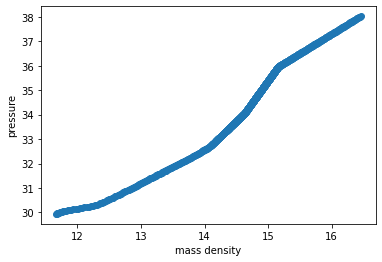

In [188]:
plt.plot(act_logdensity,act_logpressure,marker = 'o')
plt.xlabel("mass density")
plt.ylabel("pressure")
#plt.xlim([14,15.4])
#plt.ylim([32,37])

# EOS


In [131]:
#length = len(predictions)

length = 4000

In [ ]:
hlow_0 = 0.022460530117115313
hlow_1 = 0.024210313916473953
hlow = np.linspace(hlow_0,hlow_1,10,endpoint=False)
for i in range(length):

    g0 = float(predictions[i][0])
    g1 = float(predictions[i][1])
    g2 = float(predictions[i][2])
    p1 = float(predictions[i][3])
    p2 = float(predictions[i][4])
    
    if i%10==0:
        print('Progress : %d / %d, %0.2f%%'%(i,length,float(i/length*100)))
    pdat = []
    rdat = []
    #eos = lal.SimNeutronStarEOS3PieceDynamicPolytrope(g0[i],p1[i]-1,g1[i],p2[i]-1,g2[i])
    eos = lal.SimNeutronStarEOS3PieceDynamicPolytrope(g0,p1,g1,p2,g2)
    hmax = lal.SimNeutronStarEOSMaxPseudoEnthalpy(eos)
    hhigh = 10**np.linspace(np.log10(hlow_1),np.log10(hmax-.0001),100)
    hdat = np.concatenate([hlow,hhigh])
    for h in hdat:
        pdat.append(lal.SimNeutronStarEOSPressureOfPseudoEnthalpy(h,eos)*10)
        rdat.append(lal.SimNeutronStarEOSRestMassDensityOfPseudoEnthalpy(h,eos)*.001)
    #plt.plot(np.log10(rdat),np.log10(pdat),'o',alpha=0.15)
    plt.plot(np.log10(rdat),np.log10(pdat),color='purple',alpha=0.02)
plt.xlim([14,15.4])
plt.ylim([32,37])
plt.show()

Progress : 0 / 4000, 0.00%
Progress : 10 / 4000, 0.25%
Progress : 20 / 4000, 0.50%
Progress : 30 / 4000, 0.75%
Progress : 40 / 4000, 1.00%
Progress : 50 / 4000, 1.25%
Progress : 60 / 4000, 1.50%
Progress : 70 / 4000, 1.75%
Progress : 80 / 4000, 2.00%
Progress : 90 / 4000, 2.25%
Progress : 100 / 4000, 2.50%
Progress : 110 / 4000, 2.75%
Progress : 120 / 4000, 3.00%
Progress : 130 / 4000, 3.25%
Progress : 140 / 4000, 3.50%
Progress : 150 / 4000, 3.75%
Progress : 160 / 4000, 4.00%
Progress : 170 / 4000, 4.25%
Progress : 180 / 4000, 4.50%
Progress : 190 / 4000, 4.75%
Progress : 200 / 4000, 5.00%
Progress : 210 / 4000, 5.25%
Progress : 220 / 4000, 5.50%
Progress : 230 / 4000, 5.75%
Progress : 240 / 4000, 6.00%
Progress : 250 / 4000, 6.25%
Progress : 260 / 4000, 6.50%
Progress : 270 / 4000, 6.75%
Progress : 280 / 4000, 7.00%
Progress : 290 / 4000, 7.25%
Progress : 300 / 4000, 7.50%
Progress : 310 / 4000, 7.75%
Progress : 320 / 4000, 8.00%
Progress : 330 / 4000, 8.25%
Progress : 340 / 4000, 8.

Progress : 2700 / 4000, 67.50%
Progress : 2710 / 4000, 67.75%
Progress : 2720 / 4000, 68.00%
Progress : 2730 / 4000, 68.25%
Progress : 2740 / 4000, 68.50%
Progress : 2750 / 4000, 68.75%
Progress : 2760 / 4000, 69.00%
Progress : 2770 / 4000, 69.25%
Progress : 2780 / 4000, 69.50%


# Actual Values EOS

In [125]:
length = len(gamma0)

print(length)


g0 = gamma0
g1 = gamma1
g2 = gamma2
p1 = logp1_s
p2 = logp2_s


5000


Progress : 0 / 5000, 0.00%
Progress : 10 / 5000, 0.20%
Progress : 20 / 5000, 0.40%
Progress : 30 / 5000, 0.60%
Progress : 40 / 5000, 0.80%
Progress : 50 / 5000, 1.00%
Progress : 60 / 5000, 1.20%
Progress : 70 / 5000, 1.40%
Progress : 80 / 5000, 1.60%
Progress : 90 / 5000, 1.80%
Progress : 100 / 5000, 2.00%
Progress : 110 / 5000, 2.20%
Progress : 120 / 5000, 2.40%
Progress : 130 / 5000, 2.60%
Progress : 140 / 5000, 2.80%
Progress : 150 / 5000, 3.00%
Progress : 160 / 5000, 3.20%
Progress : 170 / 5000, 3.40%
Progress : 180 / 5000, 3.60%
Progress : 190 / 5000, 3.80%
Progress : 200 / 5000, 4.00%
Progress : 210 / 5000, 4.20%
Progress : 220 / 5000, 4.40%
Progress : 230 / 5000, 4.60%
Progress : 240 / 5000, 4.80%
Progress : 250 / 5000, 5.00%
Progress : 260 / 5000, 5.20%
Progress : 270 / 5000, 5.40%
Progress : 280 / 5000, 5.60%
Progress : 290 / 5000, 5.80%
Progress : 300 / 5000, 6.00%
Progress : 310 / 5000, 6.20%
Progress : 320 / 5000, 6.40%
Progress : 330 / 5000, 6.60%
Progress : 340 / 5000, 6.

GSL function failed: interpolation error (errnum=1)
XLAL Error - <GSL function> (interp.c:150): Generic failure


Progress : 1560 / 5000, 31.20%
Progress : 1570 / 5000, 31.40%
Progress : 1580 / 5000, 31.60%
Progress : 1590 / 5000, 31.80%
Progress : 1600 / 5000, 32.00%
Progress : 1610 / 5000, 32.20%
Progress : 1620 / 5000, 32.40%
Progress : 1630 / 5000, 32.60%
Progress : 1640 / 5000, 32.80%
Progress : 1650 / 5000, 33.00%
Progress : 1660 / 5000, 33.20%
Progress : 1670 / 5000, 33.40%
Progress : 1680 / 5000, 33.60%
Progress : 1690 / 5000, 33.80%
Progress : 1700 / 5000, 34.00%
Progress : 1710 / 5000, 34.20%
Progress : 1720 / 5000, 34.40%
Progress : 1730 / 5000, 34.60%
Progress : 1740 / 5000, 34.80%
Progress : 1750 / 5000, 35.00%
Progress : 1760 / 5000, 35.20%
Progress : 1770 / 5000, 35.40%
Progress : 1780 / 5000, 35.60%
Progress : 1790 / 5000, 35.80%
Progress : 1800 / 5000, 36.00%
Progress : 1810 / 5000, 36.20%
Progress : 1820 / 5000, 36.40%
Progress : 1830 / 5000, 36.60%
Progress : 1840 / 5000, 36.80%
Progress : 1850 / 5000, 37.00%
Progress : 1860 / 5000, 37.20%
Progress : 1870 / 5000, 37.40%
Progress

Progress : 4210 / 5000, 84.20%
Progress : 4220 / 5000, 84.40%
Progress : 4230 / 5000, 84.60%
Progress : 4240 / 5000, 84.80%
Progress : 4250 / 5000, 85.00%
Progress : 4260 / 5000, 85.20%
Progress : 4270 / 5000, 85.40%
Progress : 4280 / 5000, 85.60%
Progress : 4290 / 5000, 85.80%
Progress : 4300 / 5000, 86.00%
Progress : 4310 / 5000, 86.20%
Progress : 4320 / 5000, 86.40%
Progress : 4330 / 5000, 86.60%
Progress : 4340 / 5000, 86.80%
Progress : 4350 / 5000, 87.00%
Progress : 4360 / 5000, 87.20%
Progress : 4370 / 5000, 87.40%
Progress : 4380 / 5000, 87.60%
Progress : 4390 / 5000, 87.80%
Progress : 4400 / 5000, 88.00%
Progress : 4410 / 5000, 88.20%
Progress : 4420 / 5000, 88.40%
Progress : 4430 / 5000, 88.60%
Progress : 4440 / 5000, 88.80%
Progress : 4450 / 5000, 89.00%
Progress : 4460 / 5000, 89.20%
Progress : 4470 / 5000, 89.40%
Progress : 4480 / 5000, 89.60%
Progress : 4490 / 5000, 89.80%
Progress : 4500 / 5000, 90.00%
Progress : 4510 / 5000, 90.20%
Progress : 4520 / 5000, 90.40%
Progress

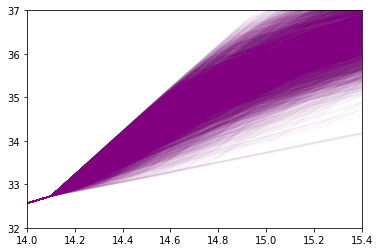

In [128]:
hlow_0 = 0.022460530117115313
hlow_1 = 0.024210313916473953
hlow = np.linspace(hlow_0,hlow_1,10,endpoint=False)
for i in range(length):

    try:
        g0 = float(gamma0[i])
        g1 = float(gamma1[i])
        g2 = float(gamma2[i])
        p1 = float(logp1_s[i])
        p2 = float(logp2_s[i])

        if i%10==0:
            print('Progress : %d / %d, %0.2f%%'%(i,length,float(i/length*100)))
        pdat = []
        rdat = []
        #eos = lal.SimNeutronStarEOS3PieceDynamicPolytrope(g0[i],p1[i]-1,g1[i],p2[i]-1,g2[i])
        eos = lal.SimNeutronStarEOS3PieceDynamicPolytrope(g0,p1,g1,p2,g2)
        hmax = lal.SimNeutronStarEOSMaxPseudoEnthalpy(eos)
        hhigh = 10**np.linspace(np.log10(hlow_1),np.log10(hmax-.0001),100)
        hdat = np.concatenate([hlow,hhigh])
        for h in hdat:
            pdat.append(lal.SimNeutronStarEOSPressureOfPseudoEnthalpy(h,eos)*10)
            rdat.append(lal.SimNeutronStarEOSRestMassDensityOfPseudoEnthalpy(h,eos)*.001)
        #plt.plot(np.log10(rdat),np.log10(pdat),'o',alpha=0.15)
        plt.plot(np.log10(rdat),np.log10(pdat),color='purple',alpha=0.02)
        
    except:
        print("fail!")
        
        
plt.xlim([14,15.4])
plt.ylim([32,37])
plt.show()

# Loss

In [185]:
history.history.keys() 

dict_keys(['loss', 'gamma0_output_loss', 'gamma1_output_loss', 'gamma2_output_loss', 'logp1_si_output_loss', 'logp2_si_output_loss', 'gamma0_output_mean_squared_error', 'gamma1_output_mean_squared_error', 'gamma2_output_mean_squared_error', 'logp1_si_output_mean_squared_error', 'logp2_si_output_mean_squared_error', 'val_loss', 'val_gamma0_output_loss', 'val_gamma1_output_loss', 'val_gamma2_output_loss', 'val_logp1_si_output_loss', 'val_logp2_si_output_loss', 'val_gamma0_output_mean_squared_error', 'val_gamma1_output_mean_squared_error', 'val_gamma2_output_mean_squared_error', 'val_logp1_si_output_mean_squared_error', 'val_logp2_si_output_mean_squared_error'])

ValueError: x and y must have same first dimension, but have shapes (63,) and (78,)

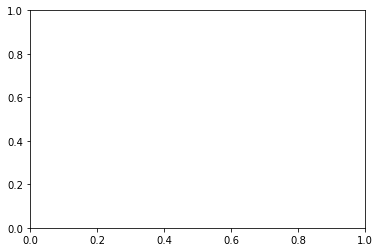

In [186]:
#loss for gamma0 values
loss_train = history.history['gamma0_output_loss']
loss_val = history.history['val_gamma0_output_loss']
epochs = range(0,63)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for gamma0')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#loss for gamma1 values
loss_train = history.history['gamma1_output_loss']
loss_val = history.history['val_gamma1_output_loss']
epochs = range(0,63)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for gamma1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#loss for gamma2 values
loss_train = history.history['gamma2_output_loss']
loss_val = history.history['val_gamma2_output_loss']
epochs = range(0,63)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for gamma2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#loss for logp1_si values
loss_train = history.history['logp1_si_output_loss']
loss_val = history.history['val_logp1_si_output_loss']
epochs = range(0,63)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for logp1_si')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


#loss for logp2_si values
loss_train = history.history['logp2_si_output_loss']
loss_val = history.history['val_logp2_si_output_loss']
epochs = range(0,63)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for logp2_si')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()